In [1]:
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
root_dir = '../../data/'

In [2]:
pd.set_option('display.max_columns', None)


In [3]:
aed_dir = root_dir + "raw/aedCoordonate.csv"

def clean_column_names(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

# df = pq.read_table(df)
aed_df = pd.read_csv(aed_dir)
aed_df["('Latitude', 'Longitude')"] = aed_df["('Latitude', 'Longitude')"].str.replace(
    r"[\(\)]", "", regex=True
)
aed_df[["latitude", "longitude"]] = aed_df["('Latitude', 'Longitude')"].str.split(
    ", ", expand=True
)

aed_df["postal_code"] = aed_df["postal_code"].astype("Int64")
aed_df["latitude"] = aed_df["latitude"].astype(np.float64)
aed_df["longitude"] = aed_df["longitude"].astype(np.float64)
aed_df = clean_column_names(aed_df)

aed_df = aed_df.loc[
    :,
    [
        "id",
        "type",
        "address",
        "number",
        "postal_code",
        "municipality",
        "province",
        "public",
        "available",
        "hours",
        "latitude",
        "longitude",
    ],
]
aed_df.dropna(subset=["id", "latitude", "longitude"], inplace=True)

In [4]:
# import requests
# api_key = "pk.585827610ef03b03ec46759d28aafb63"
# def get_lat_lon_from_address(address, api_key):
#     base_url = "https://us1.locationiq.com/v1/search.php"
#     params = {
#         "key": api_key,
#         "q": address,
#         "format": "json"
#     }
#     response = requests.get(base_url, params=params)
#     data = response.json()
    
#     if response.status_code == 200 and len(data) > 0:
#         location = data[0]
#         return location['lat'], location['lon']
#     else:
#         print("Error: Unable to geocode address")
#         return None, None

# lat, lon = get_lat_lon_from_address(address, api_key)

In [5]:
directory = root_dir + "raw/interventions"

interventions_df = pq.read_table(directory + "/interventions_bxl2.parquet.gzip")
interventions_df = interventions_df.to_pandas()
interventions_df = clean_column_names(interventions_df)

try:
    interventions_df = interventions_df.rename(columns={'eventtype_and_eventlevel': 'eventtype_trip'})
except KeyError:
    interventions_df.dropna(subset=["eventtype_and_eventlevel"], inplace=True)
    
interventions_df.dropna(subset=["eventtype_trip"], inplace=True)
interventions_df = interventions_df.loc[
    interventions_df["eventtype_trip"].str.contains("P003"), :
]

In [6]:
import os

# Specify the directory path
directory = root_dir + "raw/interventions"

list_of_file_directories = []
for filename in os.listdir(directory):
    if filename.endswith(".parquet.gzip"):
        list_of_file_directories.append(root_dir + "raw/interventions/" + filename)


interventions_df = pq.read_table(list_of_file_directories)
interventions_df = interventions_df.to_pandas()
try:
    interventions_df = interventions_df.rename(columns={'eventtype_and_eventlevel': 'eventtype_trip'})
except KeyError:
    interventions_df.dropna(subset=["eventtype_and_eventlevel"], inplace=True)
interventions_df = clean_column_names(interventions_df)    

interventions_df.dropna(subset=["eventtype_trip"], inplace=True)
interventions_df = interventions_df.loc[
    interventions_df["eventtype_trip"].str.contains("P003"), :
]


min_lat = 49.5
max_lat = 51.5
min_long = 2.5
max_long = 6.5

interventions_df = interventions_df[
    (interventions_df["latitude_intervention"] >= min_lat)
    & (interventions_df["latitude_intervention"] <= max_lat)
]
interventions_df = interventions_df[
    (interventions_df["longitude_intervention"] >= min_long)
    & (interventions_df["longitude_intervention"] <= max_long)
]
interventions_df = interventions_df[
    (interventions_df["eventtype_trip"].str.contains("P003"))
]

interventions_df = interventions_df.dropna(subset=["latitude_intervention"])
interventions_df = interventions_df.dropna(subset=["longitude_intervention"])
interventions_df.shape

(11542, 35)

In [7]:
interventions_df.to_csv("withFixedLongLat.csv")

In [8]:
# plt.scatter(x=interventions_df["latitude intervention"],y=interventions_df['longitude intervention'])
# plt.hist(x=interventions_df["longitude intervention"])
# list(interventions_df.loc[:, "eventtype trip"].unique())

In [9]:
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go
import json

# Assuming geojson is already defined and contains the GeoJSON data for Belgium
geojson = {
    # Your GeoJSON data here
}

# Create a simple map to display the GeoJSON boundaries and synthetic data points
fig = go.Figure()

# Add the GeoJSON layer
fig.update_layout(
    mapbox={
        "style": "carto-positron",
        "zoom": 7,
        "center": {"lat": 50.5039, "lon": 4.4699},
        "layers": [{"source": geojson, "type": "line", "color": "red"}],
    }
)


fig.add_trace(go.Scattermapbox(
    lat=interventions_df['latitude_intervention'],
    lon=interventions_df['longitude_intervention'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=3,
        color= 'rgba(255, 0, 0, 0.8)'
    ),
    text=[]
))

fig.add_trace(go.Scattermapbox(
    lat=aed_df['latitude'],
    lon=aed_df['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=3,
        color='blue'
    ),
    text=[]
))

fig.update_layout(margin={"r": 15, "t": 15, "l": 15, "b": 15}, height=1000)

app = dash.Dash(__name__)
app.layout = html.Div([dcc.Graph(id="map", figure=fig), html.Div(id="output-div")])
app.run_server(debug=True)

In [11]:
interventions_np = (
    interventions_df.loc[:, ["latitude_intervention", "longitude_intervention"]]
    # .sample(n=3000, replace=False)
    .to_numpy()
)
interventions_np

array([[50.928019,  4.535123],
       [50.928019,  4.535123],
       [50.767029,  4.273   ],
       ...,
       [50.03854 ,  4.26365 ],
       [50.53594 ,  4.24645 ],
       [50.53594 ,  4.24645 ]])

In [6]:
from create_graph import (
    load_data,
    Objective_function,
    cluster_interventions,
    get_list_of_u_nodes,
    get_list_of_v_nodes,
    create_graph,
    merge_degrees_event_count,
)
import numpy as np
from sklearn.cluster import DBSCAN
from preprocess import load_data
from utilities import random_coordinates_belgium, add_sampled_cooridnates_to_df


In [7]:

# ---------- Same throughout sampling ---------- #
aed_df, interventions_df = load_data(root_dir="../../data/")
aed_df = aed_df.sample(1000)  # TODO
objective_function = Objective_function(alpha=0.5)

# ----------- DBSCAN ----------- #

interventions_np = (
    interventions_df.loc[:, ["latitude_intervention", "longitude_intervention"]]
    .sample(8000)
    .to_numpy()
)

data_points = interventions_np

eps = 0.0001
min_samples = 3 
print(data_points.shape)
db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine')
db.fit(np.radians(data_points))

# labels = db.labels_
labels = db.fit_predict(np.radians(data_points))
unique_labels = set(labels) - {-1}

cluster_centers = []
for label in unique_labels:
    class_member_mask = (labels == label)
    cluster_points = np.array(data_points)[class_member_mask]
    cluster_center = np.mean(cluster_points, axis=0)
    cluster_centers.append(cluster_center)

(8000, 2)


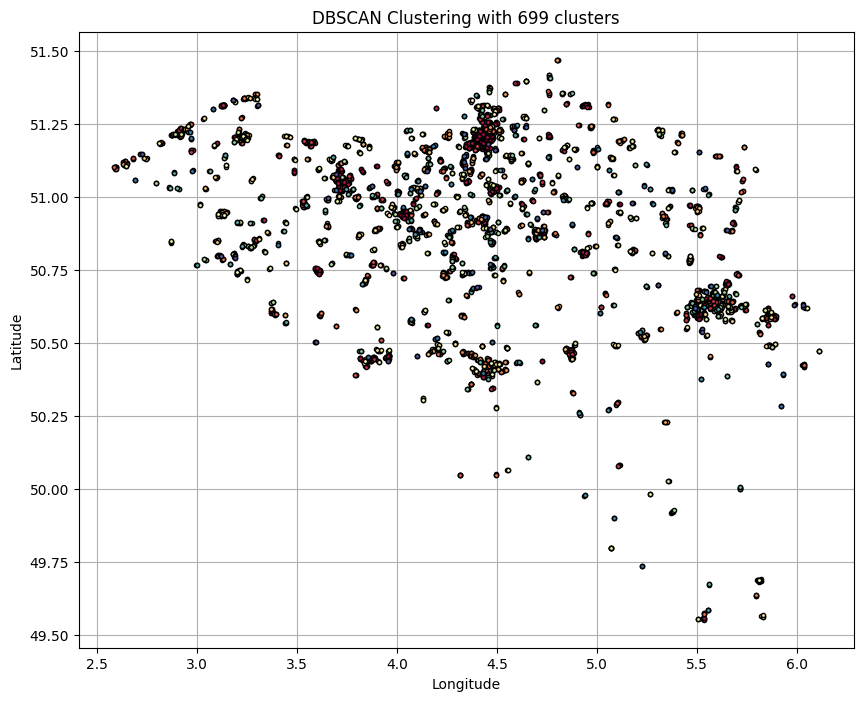

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
unique_labels = set(labels) - {-1}

# Define colors for clusters
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)

    xy = np.array(data_points)[class_member_mask]
    plt.plot(xy[:, 1], xy[:, 0], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN Clustering with {len(cluster_centers)} clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

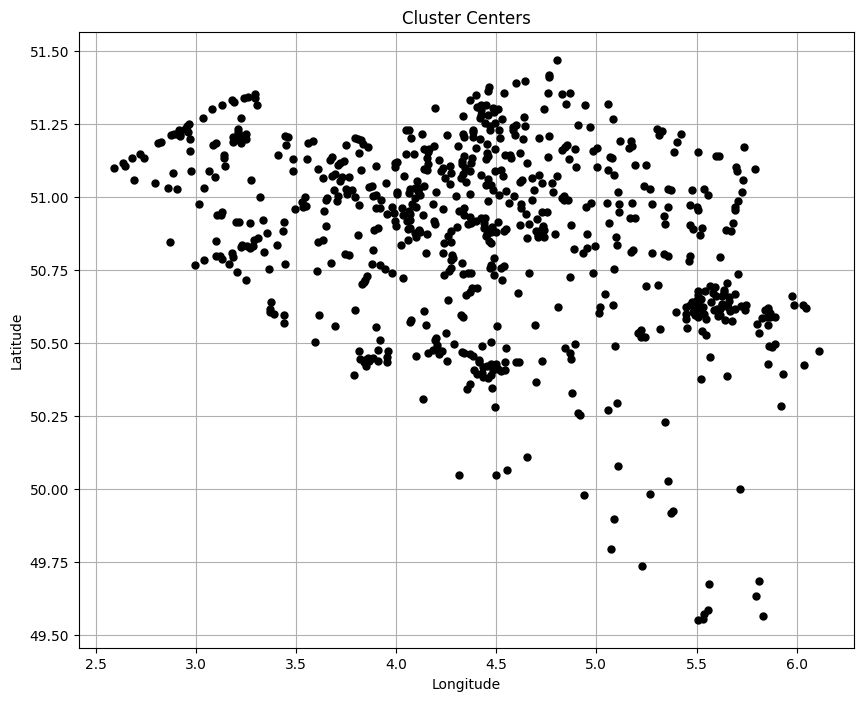

In [10]:

# Get unique labels (excluding noise points)
unique_labels = set(labels) - {-1}

# Initialize an empty list to store the cluster centers
cluster_centers = []

# Compute the centroid of each cluster
for label in unique_labels:
    class_member_mask = (labels == label)
    cluster_points = np.array(data_points)[class_member_mask]
    cluster_center = np.mean(cluster_points, axis=0)
    cluster_centers.append(cluster_center)

# Plotting
plt.figure(figsize=(10, 8))

# Plot the cluster centers
for cluster_center in cluster_centers:
    plt.plot(cluster_center[1], cluster_center[0], '.', markerfacecolor='black', markeredgecolor='k', markersize=10)

plt.title('Cluster Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [11]:
# ------------- same for all iterations ------------- #

labels, point_counts = np.unique(labels, return_counts=True)
labels, point_counts = labels[1:], point_counts[1:]  # removing -1 cluster (noise)

V = get_list_of_v_nodes(
    cluster_centers=cluster_centers, labels=labels, point_counts=point_counts
)

# ------------------- Step 0 ------------------- #

U = get_list_of_u_nodes(df=aed_df)
G = create_graph(U, V, "iteration_0/graph_0")
list_of_v_nodes = {node for node, data in G.nodes(data=True) if data["bipartite"] == 1}
v_node_degrees = {node: G.degree(node) for node in list_of_v_nodes}
m = merge_degrees_event_count(V, v_node_degrees)
loss_0 = objective_function(G, m)
print(f"U length: {len(U)}")
print(aed_df.iloc[-1, :])
print(loss_0)



U length: 1000
id                                  12353.0
type            Appareil Fixe-Vast Apparaat
address               Rue Marché Au Charbon
number                                 30.0
postal_code                            1000
municipality                      Bruxelles
province                                NaN
public                                   No
available                                No
hours                                   NaN
latitude                          50.846237
longitude                          4.350592
Name: 11917, dtype: object
9.189938778194009


In [69]:
# ------------------- Step 1 ------------------- #
best_graph = None
best_coordinates = None
best_loss = loss_0
sampling_count = 2
number_of_units_to_add = 5

for i in range(number_of_units_to_add):
    for j in range(sampling_count):
        latitude_sampled, longitude_sampled = random_coordinates_belgium()
        aed_with_sample_df = add_sampled_cooridnates_to_df(
            df=aed_df,
            id=100000+j,
            latitude=latitude_sampled,
            longitude=longitude_sampled,  # TODO fix the starting idx for samples
        )
        U = get_list_of_u_nodes(aed_with_sample_df)
        print(aed_with_sample_df.iloc[-1,:])

        print(len(U))
        G = create_graph(U, V, f"iteration_{i}/graph_{j}")
        list_of_v_nodes = {node for node, data in G.nodes(data=True) if data["bipartite"] == 1}
        v_node_degrees = {node: G.degree(node) for node in list_of_v_nodes}
        m = merge_degrees_event_count(V, v_node_degrees)
        loss_iter = objective_function(G, m)
        print(loss_iter)
        
        if loss_iter <= best_loss:
            best_graph = G
            best_coordinates = (latitude_sampled, longitude_sampled)
            best_loss = loss_iter
            aed_df = aed_with_sample_df.copy(deep=True)
        break   
    break
        

U length: 2001

id               100000.0
type                  NaN
address               NaN
number                NaN
postal_code          <NA>
municipality          NaN
province              NaN
public                NaN
available             NaN
hours                 NaN
latitude        51.152454
longitude        3.892912
Name: 2000, dtype: object
2001
8.38908999380059
U length: 2001

id               100001.0
type                  NaN
address               NaN
number                NaN
postal_code          <NA>
municipality          NaN
province              NaN
public                NaN
available             NaN
hours                 NaN
latitude        51.170605
longitude        4.266421
Name: 2000, dtype: object
2001
8.389184600884615
U length: 2001

id               100000.0
type                  NaN
address               NaN
number                NaN
postal_code          <NA>
municipality          NaN
province              NaN
public                NaN
available             N

KeyboardInterrupt: 

In [96]:
import random


def random_coordinates_belgium():
    # Define the boundaries of Belgium
    min_lat, max_lat = 50.6, 51.5
    min_long, max_long = 2.5, 6.5

    # Generate random latitude and longitude within the boundaries
    latitude = random.uniform(min_lat, max_lat)
    longitude = random.uniform(min_long, max_long)

    return latitude, longitude


def add_sampled_cooridnates_to_df(df, id, latitude, longitude):
    new_row = pd.Series({"id": id, "latitude": latitude, "longitude": longitude})

    df_temp = df.copy(deep=True)
    return pd.concat([df_temp, pd.DataFrame([new_row])], ignore_index=True)


latitude_sampled, longitude_sampled = random_coordinates_belgium()
aed_with_sample_df = add_sampled_cooridnates_to_df(
    df=aed_df,
    id=100000,
    latitude=latitude_sampled,
    longitude=longitude_sampled,  # TODO fix the starting idx for samples
)

aed_with_sample_df.tail()

,id,type,address,number,postal_code,municipality,province,public,available,hours,latitude,longitude
14144,16515.0,Appareil Fixe-Vast Apparaat,Rue Pierre Victor Jacobs,17.0,1080,Molenbeek-Saint-Jean,NaN,Yes,No,NaN,50.863358,4.339750
14145,16516.0,Appareil Fixe-Vast Apparaat,Quai Du Hainaut,69.0,1080,Molenbeek-Saint-Jean,NaN,Yes,No,NaN,50.850272,4.336024
14146,16517.0,Appareil Fixe-Vast Apparaat,Rue De Jerusalem,56.0,1030,Schaerbeek,NaN,Yes,No,NaN,50.865428,4.378332
14147,16518.0,Appareil Fixe-Vast Apparaat,Rue De Jerusalem,56.0,1030,Schaerbeek,NaN,Yes,No,NaN,50.865428,4.378332
14148,100000.0,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,51.262086,5.043380
